# Naive Bayes Classifier 
## Text Classification  (Multinomial & Bernoulli Distributions)

***Author: Rabindra Nepal***
*Email: rnepal2@unl.edu*

*Format prepared by: M. R. Hasan*

In this notebook we will apply the Naive Bayes algorithms for text classification.


### Dataset: The 20 Newsgroups data set


The 20 newsgroups dataset comprises around 20,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering. The split between the train and test set is based upon a messages posted before and after a specific date.

Following is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc


We will normalize the documents, perform preprocessing and vectorize the features. Since the features are categorical, we will implement two different naive Bayes classifiers using Scikit-Learn. 
- Categorical features (binary valued) are modeled using the Multivariate Bernoulli distrubition 
- Categorical features (multi-valued) are modeled using the Multinomial distrubition 


## Steps for Classification:

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization (Stemming & Lemmatization)
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features
3. Model Selection by Hyperparameter Tuning
4. Train the Optimal Model
5. Analyzing Model Performance
6. Evaluate the Model on Test Data

In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk import word_tokenize
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.datasets import fetch_20newsgroups

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

We will work on a partial dataset with only 4 categories out of the 20 available in the dataset:
- alt.atheism
- soc.religion.christian
- comp.graphics
- sci.med


The samples are shuffled randomly. This is useful if you wish to select only a subset of samples to quickly train a model and get a first idea of the results before re-training on the complete dataset later.

## Create Train and Test Sets 

In [2]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
X_train = train_data.data
y_train = train_data.target


test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
X_test = test_data.data
y_test = test_data.target

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

In [3]:
print("Target Names: ", train_data.target_names)

print("\nNumber of Training Examples: ", len(X_train))
print("Number of Training Labels: ", len(y_train))

print("Number of Test Examples: ",len(X_test))
print("Number of Test Labels: ", len(y_test))


print("\nPrint a Random Document:\n")
print(X_train[0])

Target Names:  ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

Number of Training Examples:  2257
Number of Training Labels:  2257
Number of Test Examples:  1502
Number of Test Labels:  1502

Print a Random Document:

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



### Class Distribution

#### Compute class distribution in the following block 

In [4]:
# first creating two DataFrames for train and test dataset

train_df = pd.DataFrame({'text': X_train, 'class': y_train})
test_df = pd.DataFrame({'text': X_test, 'class': y_test})

In [5]:
# train data

train_df['class'].value_counts()

3    599
2    594
1    584
0    480
Name: class, dtype: int64

In [6]:
# test data

test_df['class'].value_counts()

3    398
2    396
1    389
0    319
Name: class, dtype: int64

### Visualization of the Class Distribution


####  Generate visualization of the class distribution in the following block 

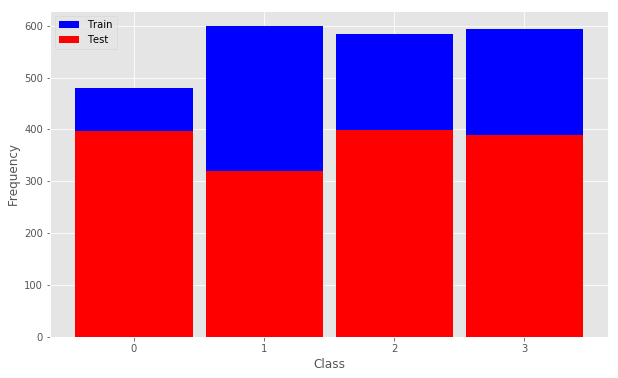

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(x=train_df['class'].unique(), height=train_df['class'].value_counts(), width=0.90 , color='b')
plt.bar(x=test_df['class'].unique(), height=test_df['class'].value_counts(), width=0.90, color='r');
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3]);
plt.legend(('Train', 'Test'));

# <font color=blue> 2. Feature Extraction </font>

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.


#### Lemmatize the training data,  stem  if it improves the classification accuracy

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
# training data
train_df['lemmatized_text'] = train_df['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) 
                                                                      for word in word_tokenize(text)]))
# testing data
test_df['lemmatized_text'] = test_df['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) 
                                                                     for word in word_tokenize(text)]))

In [10]:
# original 
train_df['text'][0]

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'

In [11]:
# lemmatized
train_df['lemmatized_text'][0]

'From : sd345 @ city.ac.uk ( Michael Collier ) Subject : Converting image to HP LaserJet III ? Nntp-Posting-Host : hampton Organization : The City University Lines : 14 Does anyone know of a good way ( standard PC application/PD utility ) to convert tif/img/tga file into LaserJet III format . We would also like to do the same , converting to HPGL ( HP plotter ) file . Please email any response . Is this the correct group ? Thanks in advance . Michael . -- Michael Collier ( Programmer ) The Computer Unit , Email : M.P.Collier @ uk.ac.city The City University , Tel : 071 477-8000 x3769 London , Fax : 071 477-8565 EC1V 0HB .'

In [24]:
# Stemming 
stemmer = PorterStemmer()

train_df['stemmed_text'] = train_df['text'].apply(lambda text: ' '.join([stemmer.stem(word) 
                                                                      for word in word_tokenize(text)]))

In [30]:
# Stemming on test data
test_df['stemmed_text'] = test_df['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) 
                                                                     for word in word_tokenize(text)]))

## <font color=blue> 2. Feature Extraction </font>

### Text Preprocessing & Feature Vectorization

We can combine text preprocessing, feature vectorization and model training using the sklearn Pipeline object. This Pipeline object can be used for model selection and for training the optimal model. 

## <font color=blue> 3. Model Selection </font>


There are no hyperparameters in a NB model except the Laplace smoothing parameter alpha.

However, there are multiple hyperparameters for the CountVectorizer() and TfidfTransformer(). We need to select the best model based on the optimal values of these hyperparameters. This process is called hyper-parameter tuning.

For hyperparameter tuning, we will build a compund classifier using the sklearn Pipeline class. It will combine the CountVectorizer(), TfidfTransformer() and MultinomialNB() objects and will create a single object.

## Building a Pipeline for Hyperparameter Tuning


####  Build a Pipeline object by combining CountVectorizer() and MultinomialNB() 

In [12]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB()),
    ])

## Hyperparameter Tuning

#### hyperparamer tuning for the following hyperparameters
- CountVectorizer()
         -- ngram_range
         -- stop_words
- MultinomialNB()
        -- alpha
        
## **<font color=red size=5>Important:</font>**

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

The macro-average ("f1_macro") will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average ("f1_micro") will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In the binary classification, "f1" score function can be used. We may also use the precision_score, recall_score, roc_auc_score functions.

In [13]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'vect__binary': [True, False],
    'clf__alpha': [0.1, 1.0, 1.5, 1.8]
}

clf_multinomial_CV = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_micro', cv=5)

clf_multinomial_CV = clf_multinomial_CV.fit(train_df['lemmatized_text'].values, train_df['class'].values)


print("\nBest Score: %f" % clf_multinomial_CV.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, clf_multinomial_CV.best_params_[param_name]))

# best scores
print("\nBest Score:")
print("\nOptimal Hyperparameter Values: ")


Best Score: 0.981391

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__binary: False
vect__ngram_range: (1, 2)
vect__stop_words: 'english'

Best Score:

Optimal Hyperparameter Values: 
Wall time: 9min 29s


## <font color=blue> 4. Train the Optimal Multinomial Model </font>

####  Using the optimal hyperparameter values, create the optimal model and then fit the model
- Build a Pipeline object by combining CountVectorizer() and MultinomialNB()

In [14]:
# best model 
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('clf', MultinomialNB(alpha=0.1))])

# training
multinomialNB_clf.fit(train_df['lemmatized_text'].values, train_df['class'].values)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [29]:
# best model with stemming

multinomialNB_clf_stemming = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('clf', MultinomialNB(alpha=0.1))])

# training
multinomialNB_clf_stemming.fit(train_df['stemmed_text'].values, train_df['class'].values)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

## <font color=blue> 6. Evaluate the Model on Test Data </font>

#### Evaluate the model on test data and generate
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report


#### Note: For multi-class classification, set the "average" attribute to "micro" for the following functions:
- precision_score
- recall_score
- f1_score

In [15]:
# prediction on test data
print('With Lemmatization')
y_test_pred = multinomialNB_clf.predict(test_df['lemmatized_text'].values)

print("\nTest Confusion Matrix:\n", confusion_matrix(test_df['class'].values, y_test_pred))
print("\nTest Precision:", precision_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest Recall:", recall_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest F1 Score:", f1_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nClassification Report:", classification_report(test_df['class'].values, y_test_pred))

With Lemmatization

Test Confusion Matrix:
 [[296   5   5  13]
 [  4 377   7   1]
 [  5  21 359  11]
 [  4   4   6 384]]

Test Precision: 0.9427430093209055

Test Recall: 0.9427430093209055

Test F1 Score: 0.9427430093209055

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.93      0.94       319
           1       0.93      0.97      0.95       389
           2       0.95      0.91      0.93       396
           3       0.94      0.96      0.95       398

   micro avg       0.94      0.94      0.94      1502
   macro avg       0.94      0.94      0.94      1502
weighted avg       0.94      0.94      0.94      1502



#### With stemming...

In [32]:
# prediction on test data: with stemming
print('With Stemming')
y_test_stem = multinomialNB_clf_stemming.predict(test_df['stemmed_text'].values)

print("\nTest Confusion Matrix:\n", confusion_matrix(test_df['class'].values, y_test_stem))
print("\nTest Precision:", precision_score(test_df['class'].values, y_test_stem, average='micro'))
print("\nTest Recall:", recall_score(test_df['class'].values, y_test_stem, average='micro'))
print("\nTest F1 Score:", f1_score(test_df['class'].values, y_test_stem, average='micro'))
print("\nClassification Report:", classification_report(test_df['class'].values, y_test_stem))

With Stemming

Test Confusion Matrix:
 [[292   6   9  12]
 [  4 382   3   0]
 [  4  39 344   9]
 [  4   7   7 380]]

Test Precision: 0.9307589880159787

Test Recall: 0.9307589880159787

Test F1 Score: 0.9307589880159787

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.92      0.94       319
           1       0.88      0.98      0.93       389
           2       0.95      0.87      0.91       396
           3       0.95      0.95      0.95       398

   micro avg       0.93      0.93      0.93      1502
   macro avg       0.93      0.93      0.93      1502
weighted avg       0.93      0.93      0.93      1502



#### No Lemmatization Results

Test Confusion Matrix:

 [[297   3   6  13]
 [  4 375   9   1]
 [  5  19 360  12]
 [  4   2   7 385]]

Test Precision: 0.9434087882822902

Test Recall: 0.9434087882822902

Test F1 Score: 0.9434087882822902

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.93      0.94       319
           1       0.94      0.96      0.95       389
           2       0.94      0.91      0.93       396
           3       0.94      0.97      0.95       398

   micro avg       0.94      0.94      0.94      1502
   
   macro avg       0.94      0.94      0.94      1502
   
weighted avg       0.94      0.94      0.94      1502

##  Multinomial NB: TF-IDF Model

####  Implement the Multinomial model using the TF-IDF feature vectors 
- Build a Pipeline object by combining CountVectorizer(), TfidfTransformer() and MultinomialNB()

In [16]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

In [17]:
%%time

# use best parameters obtained for rest: search only for tfidf hyperparameters
param_grid = {
    'vect__ngram_range': [(1, 2)],
    'vect__stop_words': ['english'],
    'vect__binary': [True],
    'clf__alpha': [0.1],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
}

clf_multinomial_CV = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_micro', cv=5)

clf_multinomial_CV = clf_multinomial_CV.fit(train_df['lemmatized_text'].values, train_df['class'].values)


print("\nBest Score: %f" % clf_multinomial_CV.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, clf_multinomial_CV.best_params_[param_name]))

# best scores
print("\nBest Score:")
print("\nOptimal Hyperparameter Values: ")


Best Score: 0.976961

Optimal Hyperparameter Values: 
clf__alpha: 0.1
tfidf__norm: 'l2'
tfidf__use_idf: True
vect__binary: True
vect__ngram_range: (1, 2)
vect__stop_words: 'english'

Best Score:

Optimal Hyperparameter Values: 
Wall time: 1min 34s


In [18]:
# best model 

multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
        ('clf', MultinomialNB(alpha=0.1)),    
])

# training
multinomialNB_clf.fit(train_df['lemmatized_text'].values, train_df['class'].values)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        s...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

## Evaluate the Model on Test Data 

#### Evaluating the model on test data and generate 
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [19]:
# prediction on test data
y_test_pred = multinomialNB_clf.predict(test_df['lemmatized_text'].values)

print("\nTest Confusion Matrix:\n", confusion_matrix(test_df['class'].values, y_test_pred))
print("\nTest Precision:", precision_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest Recall:", recall_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest F1 Score:", f1_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nClassification Report:", classification_report(test_df['class'].values, y_test_pred))


Test Confusion Matrix:
 [[276   3  11  29]
 [  1 373   8   7]
 [  5  21 353  17]
 [  3   3   6 386]]

Test Precision: 0.9241011984021305

Test Recall: 0.9241011984021305

Test F1 Score: 0.9241011984021305

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.87      0.91       319
           1       0.93      0.96      0.95       389
           2       0.93      0.89      0.91       396
           3       0.88      0.97      0.92       398

   micro avg       0.92      0.92      0.92      1502
   macro avg       0.93      0.92      0.92      1502
weighted avg       0.93      0.92      0.92      1502



#### No Lemmatization Results

Test Confusion Matrix:
 [[276   3  11  29]
 [  1 372   8   8]
 [  4  22 353  17]
 [  4   3   6 385]]

Test Precision: 0.9227696404793608

Test Recall: 0.9227696404793608

Test F1 Score: 0.9227696404793608

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.87      0.91       319
           1       0.93      0.96      0.94       389
           2       0.93      0.89      0.91       396
           3       0.88      0.97      0.92       398

   micro avg       0.92      0.92      0.92      1502
   
   macro avg       0.93      0.92      0.92      1502
   
weighted avg       0.93      0.92      0.92      1502


## <font color=maroon> Observation on Multinomial Model With TF-IDF Feature Vectors </font>

We observe that both precision and recall decrease with TF-IDF feature vectors. 

#  Multivariate Bernoulli NB

#### Task 10: Implement the Multivariate Bernoulli Model (10 pts)
- Build a Pipeline object by combining CountVectorizer() and BernoulliNB()

#### Note
The "binary" attribute of the CountVectorizer() object should be set to "True".

In [20]:
# pipeline
bernoulliNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('clf', BernoulliNB(alpha=0.1)),
    ])

bernoulliNB_clf.fit(train_df['lemmatized_text'].values, train_df['class'].values)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True))])

## Evaluate the Model on Test Data 


#### Evaluate the model on test data and generate 
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [21]:
# prediction on test data
y_test_pred = bernoulliNB_clf.predict(test_df['lemmatized_text'].values)

print("\nTest Confusion Matrix:\n", confusion_matrix(test_df['class'].values, y_test_pred))
print("\nTest Precision:", precision_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest Recall:", recall_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nTest F1 Score:", f1_score(test_df['class'].values, y_test_pred, average='micro'))
print("\nClassification Report:", classification_report(test_df['class'].values, y_test_pred))


Test Confusion Matrix:
 [[285  19   6   9]
 [  2 384   2   1]
 [  3 106 286   1]
 [  3  36   1 358]]

Test Precision: 0.874167776298269

Test Recall: 0.874167776298269

Test F1 Score: 0.874167776298269

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.89      0.93       319
           1       0.70      0.99      0.82       389
           2       0.97      0.72      0.83       396
           3       0.97      0.90      0.93       398

   micro avg       0.87      0.87      0.87      1502
   macro avg       0.90      0.88      0.88      1502
weighted avg       0.90      0.87      0.88      1502



#### No Lemmatization Results

Test Confusion Matrix:
 [[288  18   5   8]
 [  2 385   2   0]
 [  3 107 284   2]
 [  3  36   1 358]]

Test Precision: 0.8754993342210386

Test Recall: 0.8754993342210386

Test F1 Score: 0.8754993342210386

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.90      0.94       319
           1       0.71      0.99      0.82       389
           2       0.97      0.72      0.83       396
           3       0.97      0.90      0.93       398

   micro avg       0.88      0.88      0.88      1502
   
   macro avg       0.91      0.88      0.88      1502
   
weighted avg       0.90      0.88      0.88      1502

##  Observation on Multivariate Bernoulli Model 

#### Summerize:
- Impact of data normalization technique.
- Which classifier gave the best precision? Best recall? Best F1 Score? Explain their performance variance.


From the above experimentations we conclude the following:

- Data normalization:

We checked the performance of the model both with lemmatization and without lemmatization. From the experiments, it is observed that the performance of the model is not affected that much by the lemmatization. As listed the results above, the performance of the models are changed by a very very small amount and the change is not consistent (increase or decrease) in the three different models we checked above. So, the conclusion is that eventhough the lemmatization affects the results, it is not affected significantly in this case. 

However, with stemming of the text, we find the performance of the model suffered a little bit. we find the consistent decrease in the performance scores of the models by about a percent.

- Performance Variance

The multinomial model without TfidfTransformer gives the best performances for all metrics: precision, recall and f1_score than multinoial model with TfidfTransformer and multinomial Bernoulli model. Also, one important to notice is that the precision, recall and f1_scores of each of the model are almost equal implying that each of the model is not biased. 

***Done!***